# Getting up to speed

First of all, key imports.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

Read in the data we've cleaned and visualized.

In [2]:
filepath = '../data/processed/cleaned_data.pkl'
data = pd.read_pickle(filepath)
data.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,227360.0,0.941,0.79200,1,0.115,-5.201,1,0.0748,100.889,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,5,0.124,-7.043,1,0.0300,115.002,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,11,0.534,-4.617,0,0.0345,127.994,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,4,0.157,-4.498,0,0.2390,128.014,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,9,0.157,-6.266,0,0.0413,145.036,0.323,Electronic


# Laying out the steps

In this pre-processing and training data set notebook, we're interested in three tasks: scaling the data, creating dummy variables, and creating a test-train split. Actually, we created dummy variables *labels* before, but let's revert back and then actually perform dummy encoding for features. Also, we know that any scaling should not see the test data set, so we should perform the split first. In summary:
1. Decode labels
2. Test-train split
3. One hot encoding
4. Scaling

# Doing the transformations

In [3]:
with open('../encoders/key_encoder.pkl', 'rb') as handle:
    key_encoder = pickle.load(handle)
with open('../encoders/mode_encoder.pkl', 'rb') as handle:
    mode_encoder = pickle.load(handle)

In [4]:
data['key'] = key_encoder.inverse_transform(data['key'])
data['mode'] = mode_encoder.inverse_transform(data['mode'])
data.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,227360.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.002,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic


In [5]:
from sklearn.model_selection import train_test_split
X = data.drop(columns='music_genre')
y = data.music_genre
X_train, X_test, y_train, y_test = train_test_split(X, y)

The purpose of using scikit-learn's OneHotEncoder instead of pandas' get_dummies is to save the encoder to be applied to the test set.

In [6]:
from sklearn.preprocessing import OneHotEncoder

OH = OneHotEncoder(drop='first', sparse=False)
OH_array_train = OH.fit_transform(X_train[['key', 'mode']])

#Convert returned array to DataFrame
OH_df_train = pd.DataFrame(OH_array_train)

#Get the category names from the encoder
OH_df_train.columns = OH.categories_[0][1:].tolist() + OH.categories_[1][1:].tolist()

#Reset X_train index for concatenation
X_train = pd.concat([X_train.reset_index(drop=True), OH_df_train], axis=1)

#clean up
X_train.drop(columns=['key', 'mode'], inplace=True)

At this point, most of the features are between 0 and 1. The only exceptions are `popularity`, `duration_ms`, `loudness`, and `tempo`. From our EDA, we can see that `popularity` and `tempo` are normally distributed, but `duration_ms` and `loudness` are highly skewed. Therefore, we'll use a power transformer on `duration_ms` and `loudness`, then a min-max scaler on all `popularity`, `duration_ms`, `loudness`, and `tempo`. The choice of a min-max scaler is to put all features on the same scale as the existing features such as `acousticness`. However, we also know that `acousticness`, `instrumentalness`, `liveness`, and `speechiness` are also not normally distributed, we'll apply the power transformer to them, too, and scale them back to between 0 and 1.

In [7]:
X_train.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,C,C#,D,D#,E,F,F#,G,G#,Minor
count,37500.000000,37500.000000,37500.000000,3.750000e+04,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,...,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000
mean,44.158267,0.306824,0.558101,2.438247e+05,0.599656,0.181707,0.193723,-9.122890,0.093333,119.893102,...,0.109573,0.107760,0.103760,0.031307,0.074213,0.089387,0.061813,0.115467,0.066427,0.359280
std,15.563571,0.341276,0.178337,1.078642e+05,0.264469,0.325281,0.161266,6.150502,0.101043,29.051033,...,0.312361,0.310081,0.304953,0.174148,0.262121,0.285305,0.240819,0.319589,0.249030,0.479796
min,0.000000,0.000000,0.059600,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022400,34.347000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,0.020300,0.442000,1.952000e+05,0.432000,0.000000,0.097075,-10.843000,0.036100,96.618000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,0.145000,0.568000,2.273600e+05,0.642000,0.000162,0.126000,-7.269000,0.048800,119.952961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.551000,0.686000,2.683862e+05,0.816000,0.156000,0.243000,-5.174000,0.097900,139.484750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.994000,1.000000,3.744000,0.941000,220.041000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
from sklearn.preprocessing import PowerTransformer
PT = PowerTransformer(standardize=False)
X_train[['acousticness', 'duration_ms', 'instrumentalness', 'liveness', 'loudness', 'speechiness']] = \
        PT.fit_transform(X_train[['acousticness', 'duration_ms', 'instrumentalness', 'liveness', 'loudness', 'speechiness']])

In [9]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
X_train[['popularity', 'acousticness', 'duration_ms', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']]= \
        MMS.fit_transform(
        X_train[['popularity', 'acousticness', 'duration_ms', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']]
        )        

In [10]:
X_train.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,C,C#,D,D#,E,F,F#,G,G#,Minor
count,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,...,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000
mean,0.446043,0.426144,0.558101,0.443958,0.599656,0.265299,0.580905,0.123467,0.417829,0.460683,...,0.109573,0.107760,0.103760,0.031307,0.074213,0.089387,0.061813,0.115467,0.066427,0.359280
std,0.157208,0.369346,0.178337,0.060479,0.264469,0.406266,0.206416,0.038380,0.299899,0.156446,...,0.312361,0.310081,0.304953,0.174148,0.262121,0.285305,0.240819,0.319589,0.249030,0.479796
min,0.000000,0.000000,0.059600,0.000000,0.000792,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.343434,0.057785,0.442000,0.416256,0.432000,0.000000,0.430838,0.101825,0.175048,0.335342,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.454545,0.340974,0.568000,0.442530,0.642000,0.001034,0.523506,0.127540,0.308269,0.461006,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.555556,0.802826,0.686000,0.471271,0.816000,0.608007,0.759207,0.148334,0.643009,0.566188,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,0.986000,1.000000,0.999000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


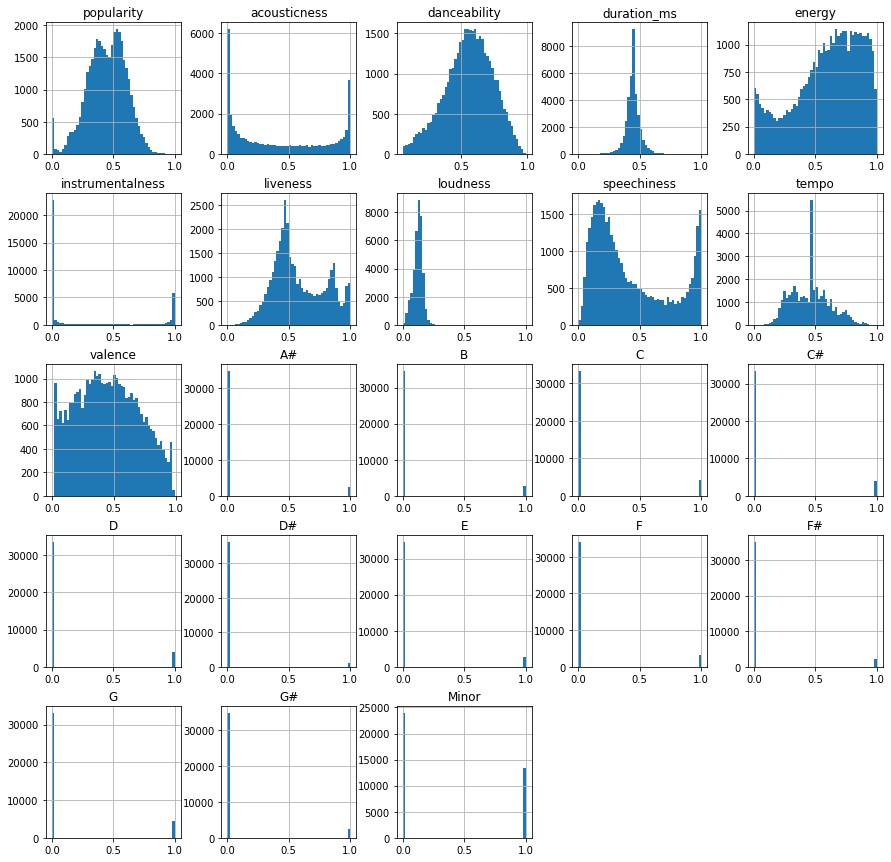

In [11]:
X_train.hist(figsize=(15, 15), bins=50)
plt.show()

Looks great! Let's finally apply our transformations to the test set.

In [12]:
#One Hot Encoding
OH_array_test = OH.transform(X_test[['key', 'mode']])
OH_df_test = pd.DataFrame(OH_array_test)
OH_df_test.columns = OH.categories_[0][1:].tolist() + OH.categories_[1][1:].tolist()
X_test = pd.concat([X_test.reset_index(drop=True), OH_df_test], axis=1)
X_test.drop(columns=['key', 'mode'], inplace=True)

#Power Transformer
X_test[['acousticness', 'duration_ms', 'instrumentalness', 'liveness', 'loudness', 'speechiness']] = \
        PT.transform(X_test[['acousticness', 'duration_ms', 'instrumentalness', 'liveness', 'loudness', 'speechiness']])

#Min-Max Scaler
X_test[['popularity', 'acousticness', 'duration_ms', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']]= \
        MMS.fit_transform(
        X_test[['popularity', 'acousticness', 'duration_ms', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']]
        )

In [13]:
#resetting the index for y data to match X
y_train = y_train.reset_index(drop=True).squeeze(axis=0)
y_test = y_test.reset_index(drop=True).squeeze(axis=0)

# Saving the data for modeling

In [14]:
#paths to saved data files
X_train_path = '../data/processed/X_train.pkl'
X_test_path = '../data/processed/X_test.pkl'
y_train_path = '../data/processed/y_train.pkl'
y_test_path = '../data/processed/y_test.pkl'

#Pickling
with open(X_train_path, 'wb') as handle:
    pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(X_test_path, 'wb') as handle:
    pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(y_train_path, 'wb') as handle:
    pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(y_test_path, 'wb') as handle:
    pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)